# This is going to be the final notebook to present all findings

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import src.visualization as vs
import src.process as process
import src.json_cleaning as jc
import src.cleaning as cl
import models.lib as modlib

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, KFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score, recall_score, precision_score
from sklearn.metrics import classification_report, roc_curve, confusion_matrix

# models
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

from xgboost import XGBClassifier

RSEED = 42

In [19]:
df = pd.read_csv('data/raw/kickstarter.csv')

In [20]:
#Convert the funding goal into USD to make it comparable across all projects
data = cl.convert_goal_to_usd(df)

#Create a new column for pledge per backer and drop backers_count afterwards
data = cl.convert_backers_pledged(data)

#Create new columns that contain the word counts for project name and blurb columns
data =cl.convert_string_wordcount(data)

#Decipher the json-format in the category column into category_name and parent_category columns
data =cl.convert_categories(data)

#Convert the date related columns into timeframes in seconds and categories for month/weekday/day_hour
data =cl.convert_times(data)

#Convert the target columns to binary 1/0 values and drop all rows that aren't successful or failed
data =cl.convert_drop_labels(data)

#Drop duplicate rows, and rows that are duplicated and rows that only differ in usd_type
data =cl.drop_duplicates(data)

data.head()



,converted_pledged_amount,country,creator,currency,currency_symbol,currency_trailing_code,current_currency,disable_communication,friends,fx_rate,...,pledge_per_backer,len_blurb,len_name,category_name,parent_category,launch_to_deadline,creation_to_launch,month,weekday,day_hour
1,1950,US,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",USD,$,True,USD,False,NaN,1.000000,...,41.49,22.0,4,Playing Cards,games,2592000,700366,August,Thursday,17
2,22404,US,"{""id"":323849677,""name"":""Electra"",""is_registere...",USD,$,True,USD,False,NaN,1.000000,...,82.67,15.0,7,Rock,music,2592000,19433862,May,Monday,5
3,165,GB,"{""id"":196281496,""name"":""Artur Ordijanc (delete...",GBP,£,False,USD,False,NaN,1.308394,...,55.13,23.0,8,Playing Cards,games,5180400,465105,January,Thursday,18
4,2820,US,"{""id"":1178460181,""name"":""Dawn Johnston"",""is_re...",USD,$,True,USD,False,NaN,1.000000,...,940.00,24.0,7,Nonfiction,publishing,2592000,354456,December,Monday,20
5,3725,US,"{""id"":682189804,""name"":""Annapolis Chamber Play...",USD,$,True,USD,False,NaN,1.000000,...,106.43,18.0,4,Classical Music,music,2592000,13769396,April,Thursday,2


In [21]:
#Drop colums that cannot be used
drop_these = [
        'converted_pledged_amount',
        'currency',
        'currency_symbol',
        'currency_trailing_code',
        'current_currency',
        'disable_communication',
        'friends',
        'fx_rate',
        'id',
        'is_backing',
        'is_starrable',
        'is_starred',
        'permissions',
        'pledged',
        'slug',
        'source_url',
        'spotlight',
        'state_changed_at',
        'urls',
        ]

drop_these_too = [
        'creator',
        'location',
        'photo',
        'profile',
        ]

data.drop(drop_these, axis=1, inplace=True)
data.drop(drop_these_too, axis=1, inplace=True)
data.head()

,country,staff_pick,state,usd_pledged,usd_type,converted_goal,pledge_per_backer,len_blurb,len_name,category_name,parent_category,launch_to_deadline,creation_to_launch,month,weekday,day_hour
1,US,False,1,1950.00,domestic,1000.00,41.49,22.0,4,Playing Cards,games,2592000,700366,August,Thursday,17
2,US,False,1,22404.00,international,15000.00,82.67,15.0,7,Rock,music,2592000,19433862,May,Monday,5
3,GB,False,0,165.38,domestic,12160.66,55.13,23.0,8,Playing Cards,games,5180400,465105,January,Thursday,18
4,US,False,1,2820.00,domestic,2800.00,940.00,24.0,7,Nonfiction,publishing,2592000,354456,December,Monday,20
5,US,False,1,3725.00,domestic,3500.00,106.43,18.0,4,Classical Music,music,2592000,13769396,April,Thursday,2


In [22]:
#Save the result of data cleaning
data.to_csv('data/processed/kickstarter_clean.csv', index = False)

In [23]:
data = pd.read_csv('data/processed/kickstarter_clean.csv')
data.head()

,country,staff_pick,state,usd_pledged,usd_type,converted_goal,pledge_per_backer,len_blurb,len_name,category_name,parent_category,launch_to_deadline,creation_to_launch,month,weekday,day_hour
0,US,False,1,1950.00,domestic,1000.00,41.49,22.0,4,Playing Cards,games,2592000,700366,August,Thursday,17
1,US,False,1,22404.00,international,15000.00,82.67,15.0,7,Rock,music,2592000,19433862,May,Monday,5
2,GB,False,0,165.38,domestic,12160.66,55.13,23.0,8,Playing Cards,games,5180400,465105,January,Thursday,18
3,US,False,1,2820.00,domestic,2800.00,940.00,24.0,7,Nonfiction,publishing,2592000,354456,December,Monday,20
4,US,False,1,3725.00,domestic,3500.00,106.43,18.0,4,Classical Music,music,2592000,13769396,April,Thursday,2


In [24]:
vs.nice_summary(data).sort_values('Dtype')

,Columns,Dtype,nunique,Non-Null Count,Missing,Missing %,Zero Count,mean,std,min,25%,50%,75%,max
1,staff_pick,bool,2,168979,-,-,147323,-,-,-,-,-,-,-
2,state,int64,2,168979,-,-,74200,0.56,0.5,0.0,0.0,1.0,1.0,1.0
8,len_name,int64,20,168979,-,-,0,5.71,2.71,1.0,4.0,6.0,8.0,27.0
11,launch_to_deadline,int64,47963,168979,-,-,0,2821257.19,1015877.11,86400.0,2588400.0,2592000.0,2948818.5,8044324.0
12,creation_to_launch,int64,160540,168979,-,-,0,4035541.38,11023976.34,236.0,248844.5,943224.0,3098481.0,285428640.0
15,day_hour,int64,24,168979,-,-,7383,13.58,6.94,0.0,8.0,15.0,19.0,23.0
3,usd_pledged,float64,69802,168979,-,-,14821,12110.97,83739.29,0.0,100.0,1457.0,6235.0,8596474.58
5,converted_goal,float64,45238,168979,-,-,0,41096.88,1110956.93,0.01,1500.0,5000.0,13297.7,152350076.0
6,pledge_per_backer,float64,25710,154158,14821,8.77,0,78.74,140.81,0.46,27.14,50.55,89.3,10000.0
7,len_blurb,float64,35,168977,2,-,0,19.01,4.98,1.0,16.0,20.0,22.0,35.0


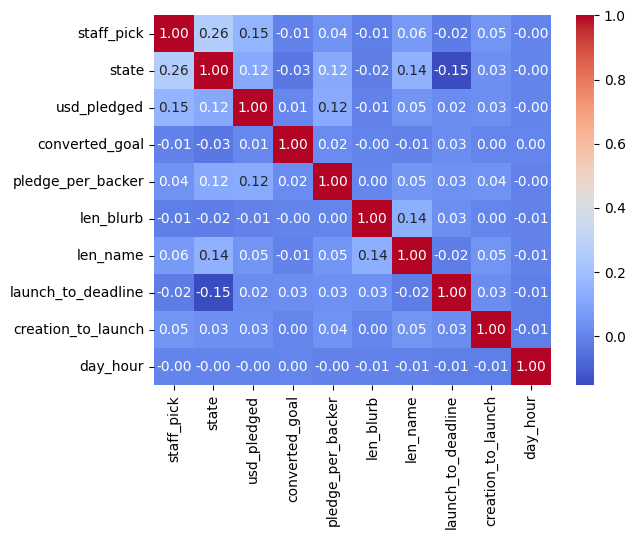

<Figure size 2000x1500 with 0 Axes>

In [30]:
# Create a correlation matrix
#Shows that must of the features have low impact, staff_pick sticks out
corr = data.corr()

# Create a heatmap using seaborn
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt= '.2f')

# Show the plot
plt.figure(figsize = (20, 15))
plt.show()

In [38]:
#Visual investigation of different features
df = data.copy()
df.head()

,country,staff_pick,state,usd_pledged,usd_type,converted_goal,pledge_per_backer,len_blurb,len_name,category_name,parent_category,launch_to_deadline,creation_to_launch,month,weekday,day_hour
0,US,False,1,1950.00,domestic,1000.00,41.49,22.0,4,Playing Cards,games,2592000,700366,August,Thursday,17
1,US,False,1,22404.00,international,15000.00,82.67,15.0,7,Rock,music,2592000,19433862,May,Monday,5
2,GB,False,0,165.38,domestic,12160.66,55.13,23.0,8,Playing Cards,games,5180400,465105,January,Thursday,18
3,US,False,1,2820.00,domestic,2800.00,940.00,24.0,7,Nonfiction,publishing,2592000,354456,December,Monday,20
4,US,False,1,3725.00,domestic,3500.00,106.43,18.0,4,Classical Music,music,2592000,13769396,April,Thursday,2


<AxesSubplot:xlabel='staff_pick', ylabel='count'>

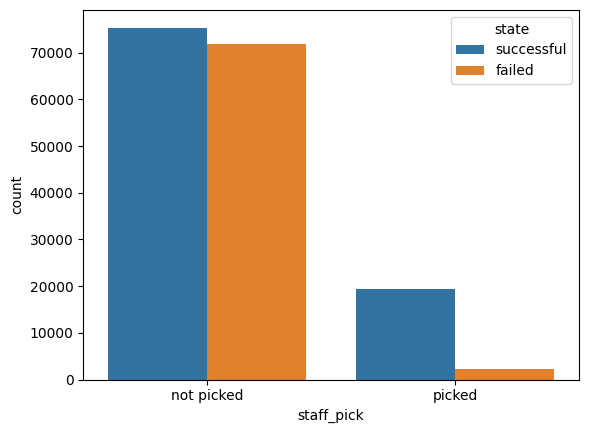

In [39]:
df['state'] = data['state'].replace({0:'failed', 1 :'successful'})
df['staff_pick'] = data['staff_pick'].replace({True:'picked', False:"not picked"})
sns.countplot(data = df, x = 'staff_pick', hue = 'state')

<AxesSubplot:xlabel='Name length in words', ylabel='count'>

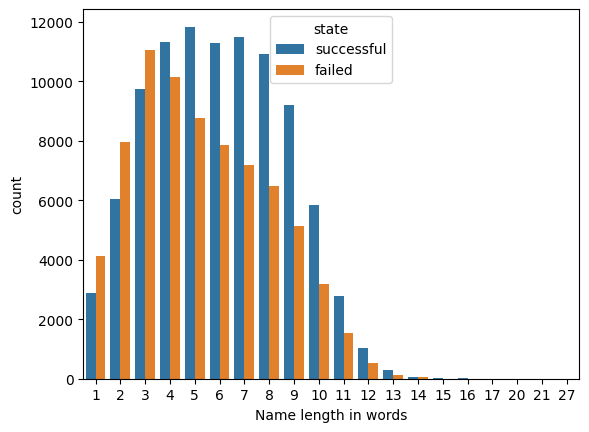

In [42]:
df.rename(columns={'len_name': 'Name length in words', 'len_blurb' : 'Description length in words'}, inplace = True)
sns.countplot(data = df, x = 'Name length in words', hue = 'state')

<AxesSubplot:xlabel='Description length in words', ylabel='count'>

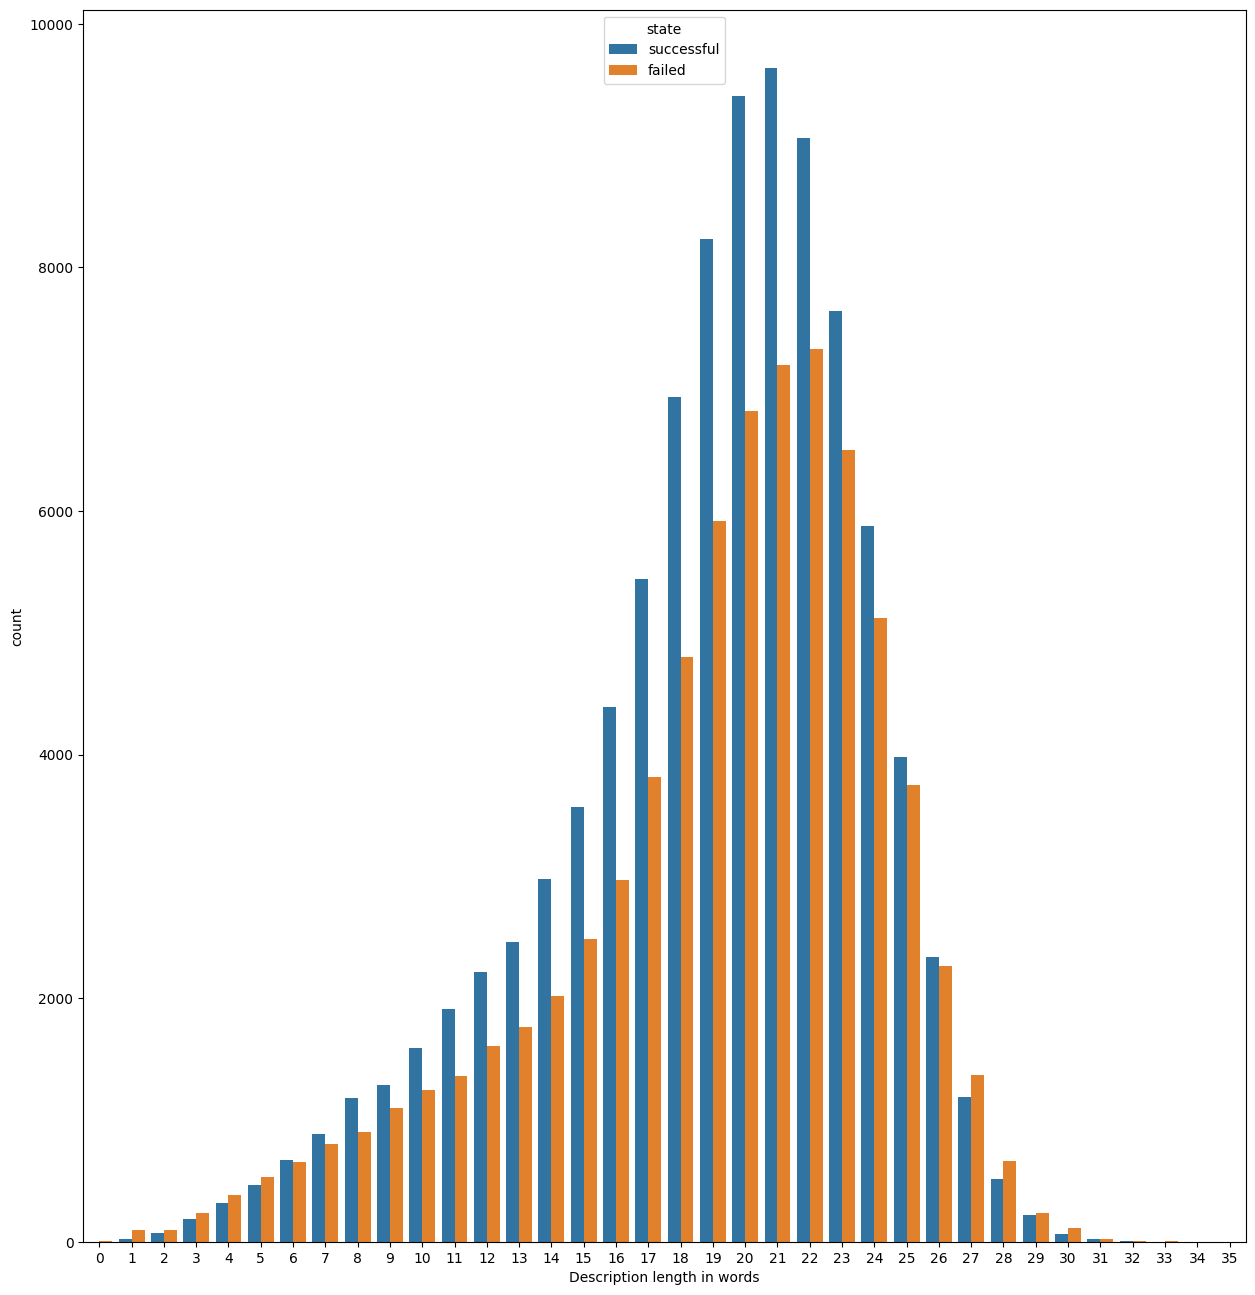

In [43]:
plt.subplots(figsize=(15, 16))
df['Description length in words'].fillna(0, inplace = True)
df['Description length in words'] = df['Description length in words'].astype(int)
sns.countplot(data = df, x = 'Description length in words', hue= 'state')

<AxesSubplot:xlabel='Run time in days', ylabel='count'>

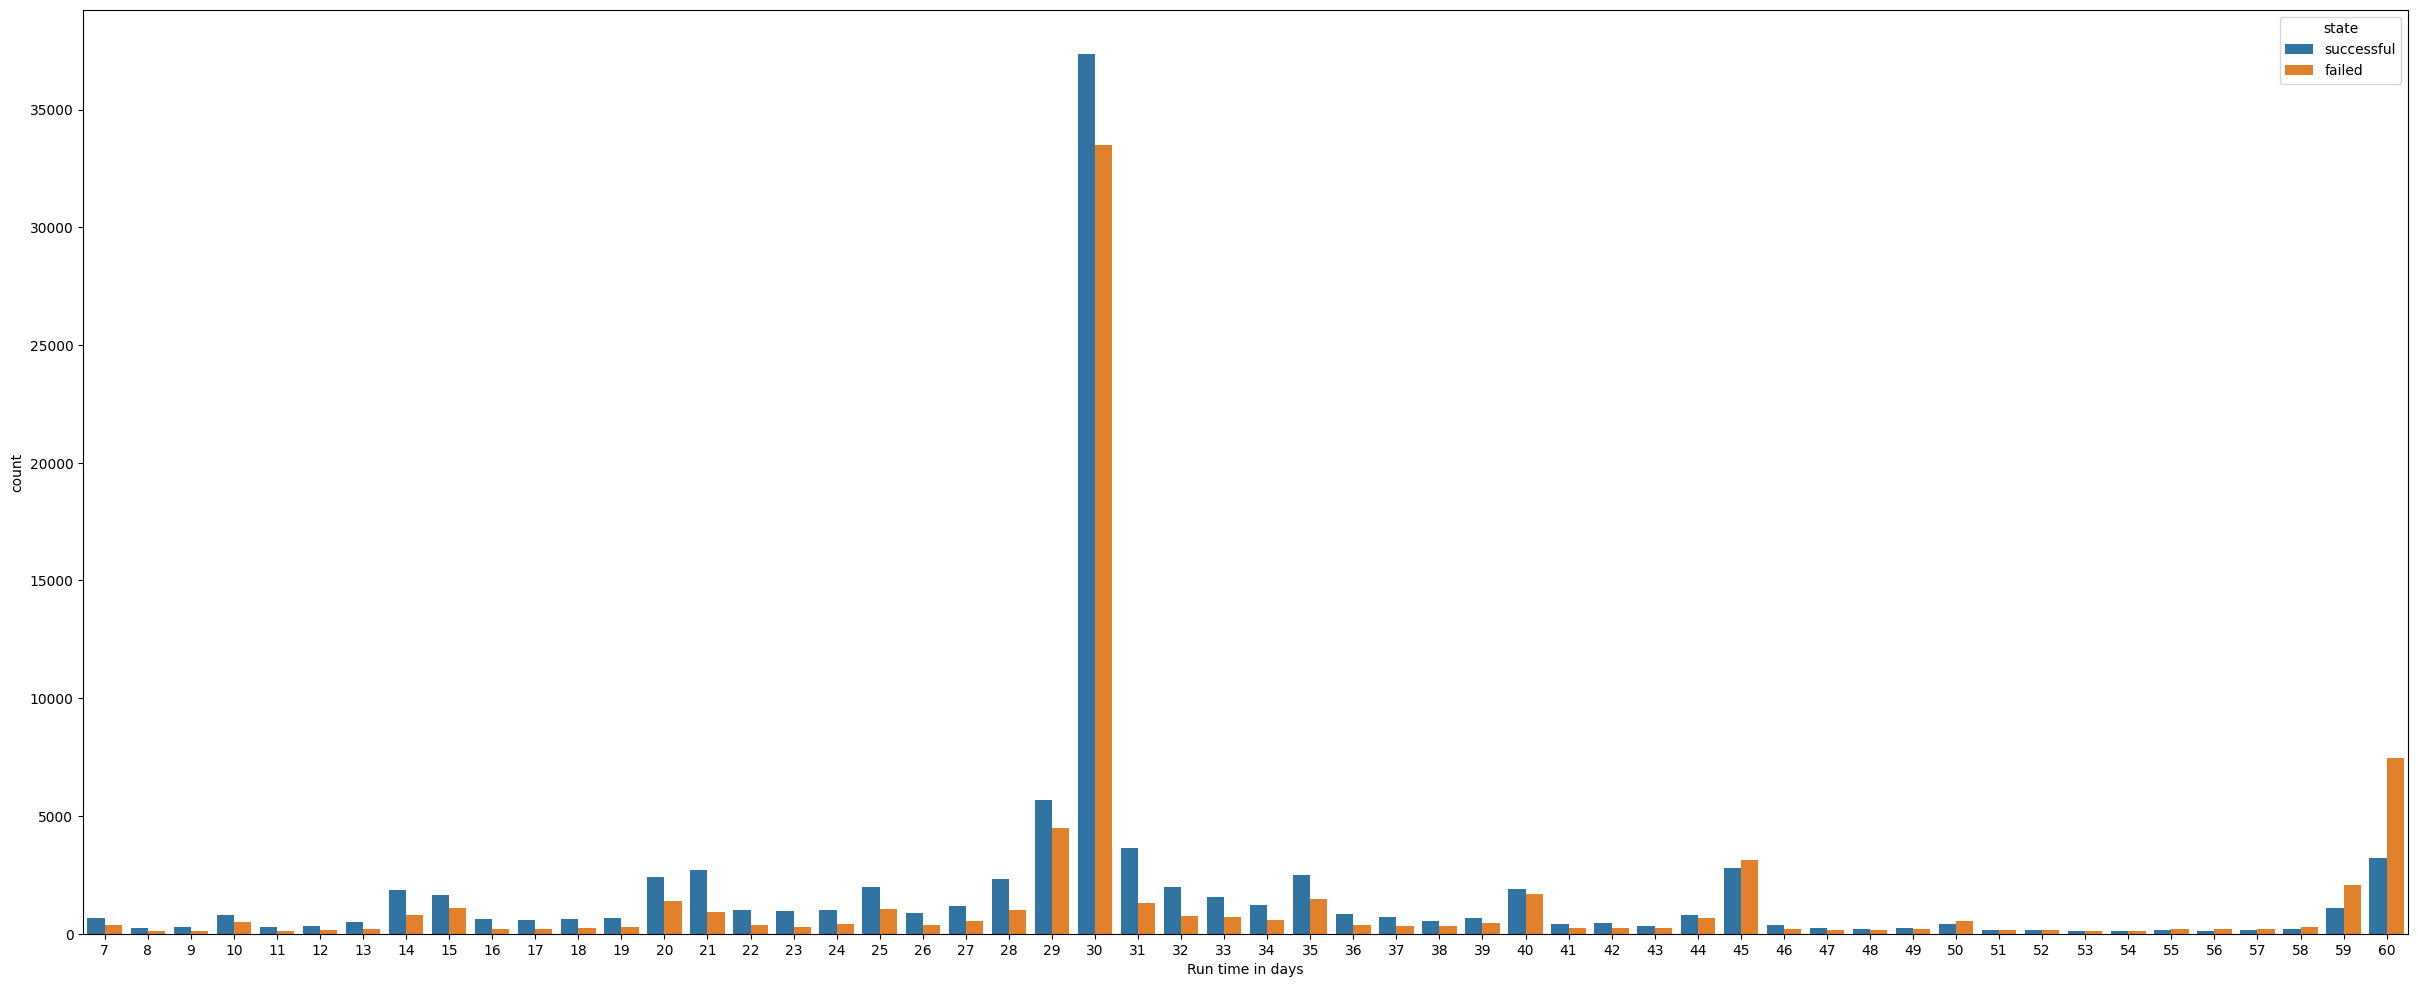

In [44]:
plt.subplots(figsize=(30, 12))
df['Run time in days'] = df.launch_to_deadline/60/60//24
df['Run time in days'] = df['Run time in days'].astype(int)

filtered = df[(df['Run time in days'] < 61) & (df['Run time in days'] > 6)]

sns.countplot(data = filtered, x = 'Run time in days', hue = 'state')

<AxesSubplot:xlabel='country', ylabel='count'>

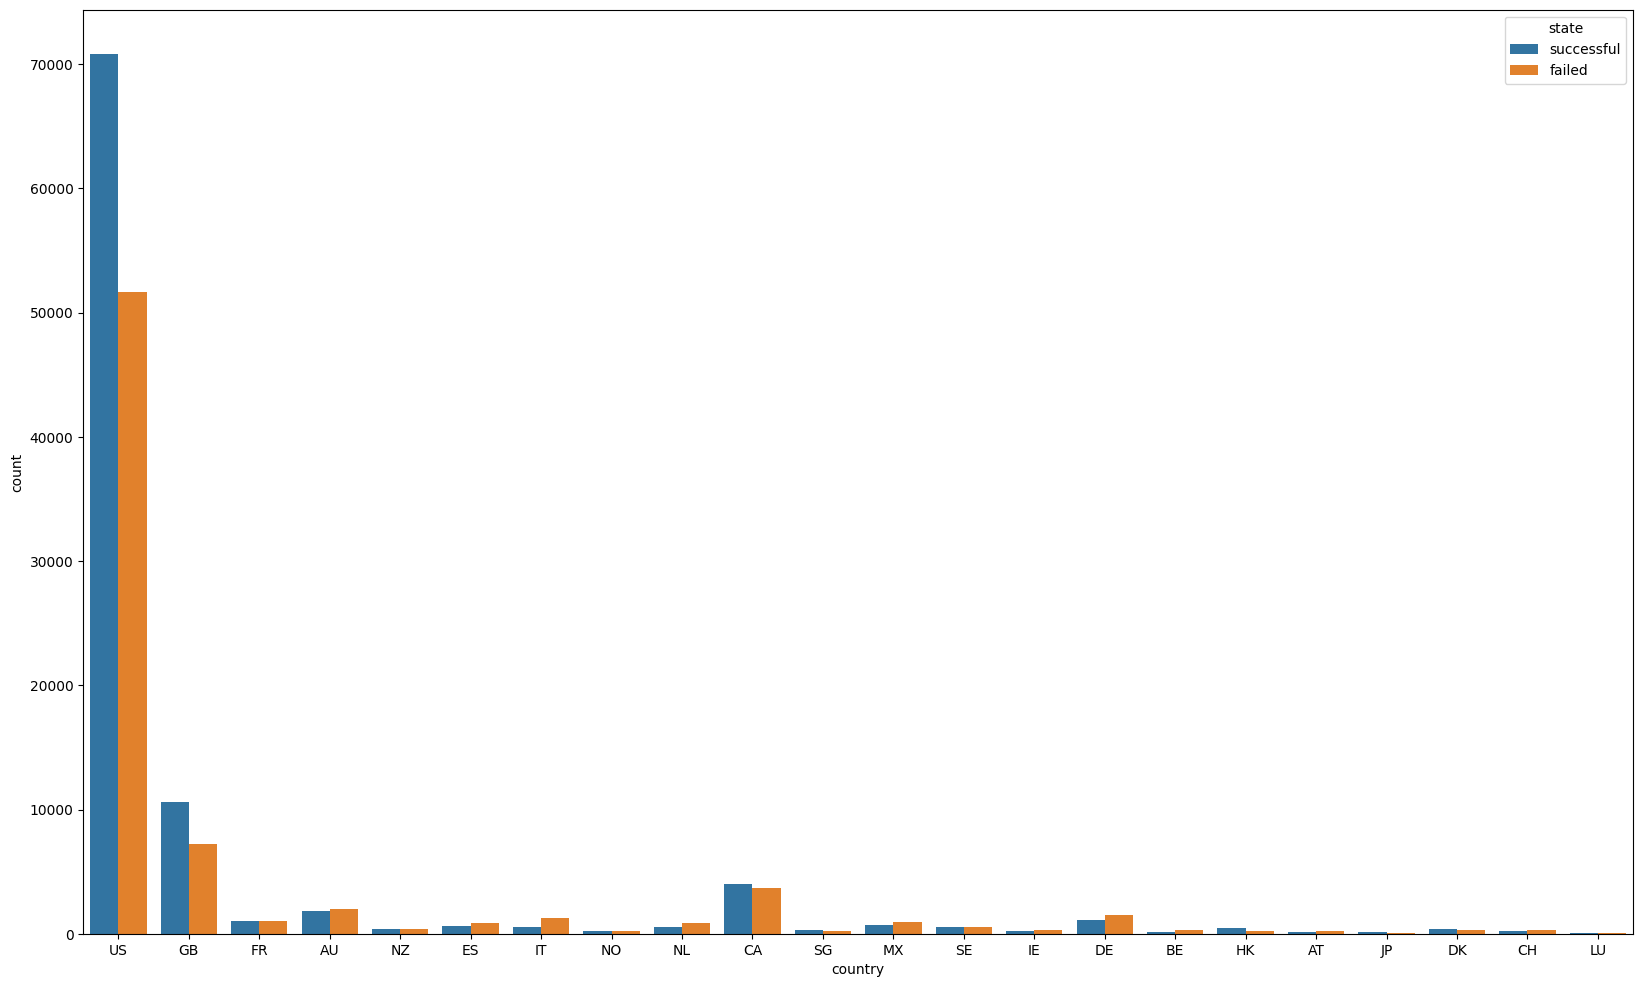

In [45]:
plt.subplots(figsize=(20, 12))
sns.countplot(data = df, x= 'country', hue = 'state')

<AxesSubplot:xlabel='country'>

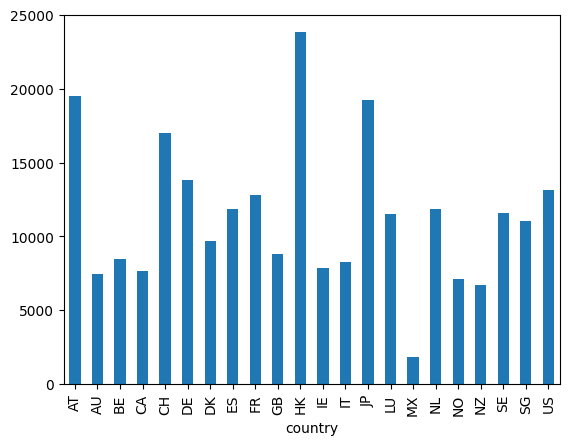

In [46]:
df.groupby('country').usd_pledged.mean().plot(kind='bar')

In [ ]:
df.groupby('parent_category').usd_pledged.median().plot(kind='bar')

In [31]:
#Creation of a base line model based on the staff_pick
fbeta = round(fbeta_score(data.state, data.staff_pick, beta=0.5), 3)
accuracy = round(accuracy_score(data.state, data.staff_pick), 3)
recall = round(recall_score(data.state, data.staff_pick), 3)
precision = round(precision_score(data.state, data.staff_pick), 3)

scores = pd.DataFrame()    
scores['base model'] = [fbeta, accuracy, recall, precision]

# few false positives: staff_picked it, but it wasn't successful
# many false negatives: staff didn't pick it, but they were successful

display(scores)

# 13.5% are staff picked
data.query('staff_pick == True').state.value_counts()

,base model
0,0.535
1,0.541
2,0.205
3,0.896


1    19404
0     2252
Name: state, dtype: int64

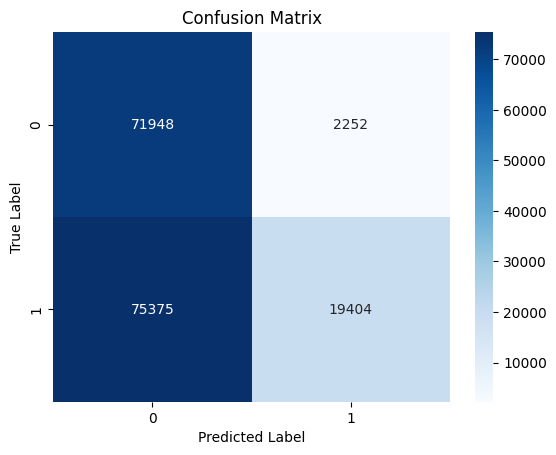

In [32]:
# Calculate the confusion matrix of the base line model
cm = confusion_matrix(data.state, data.staff_pick)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [23]:
data = data.drop(['staff_pick','usd_pledged','backers_count'], axis=1)
data.day_hour = data.day_hour.astype(str)
data.sample(5, random_state=RSEED)

,country,state,usd_type,converted_goal,len_blurb,len_name,launch_to_deadline,creation_to_launch,month,weekday,day_hour,category_name
10790,US,1,international,2000.00,8.0,8,2694818,1742779,November,Friday,1,Rock
26459,CA,1,domestic,4743.59,13.0,7,2592000,349404,November,Wednesday,14,Nonfiction
168147,US,1,domestic,4000.00,18.0,7,3024000,16619516,April,Friday,4,Dance
32580,US,0,international,35000.00,17.0,2,2592000,6379447,July,Tuesday,18,Periodicals
156442,US,0,domestic,4000.00,26.0,4,5130896,1349404,January,Monday,17,Public Art


## Preprocessing
- Performing train-test-split
- defining target variable = 'state' -> binary success/failure
- splitting categories up in numerical and categorical features for separate preprocessing
- load models from /models/lib.py
- Applying StandardScaler() to numerical features and imputing them with median() where necessary using SimpleImpute() -> not necessary in this dataset
- Applying OneHotEncoding() to categorical features and dropping the first. Imputing with "missing" where necessary using SimpleImpute() -> not necessary in this dataset

In [24]:
y = data['state']
X = data.drop('state', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, stratify = y, test_size = 0.2, random_state = RSEED)

target = 'state'
num_features, cat_features = process.num_cat_features(data, target=target)
models = modlib.models()

preprocessor = process.create_preprocessor(num_features, cat_features)
scaled_models = process.model_process_pipeline(models, preprocessor, prefix='scaled')

Categorical Features: ['country', 'usd_type', 'month', 'weekday', 'day_hour', 'category_name'] 
Numerical Features: ['converted_goal', 'len_blurb', 'len_name', 'launch_to_deadline', 'creation_to_launch']


## Cross Validation
- to get a rough idea which models might perform best

In [26]:
predicted_y_dict = process.model_cv_scores(X_train, y_train, scaled_models, kfolds=10, RSEED=42, shuffle=True, n_jobs=1)
display(vs.nice_scores(y_train, predicted_y_dict))

scaledDT - Time taken: 147.40 seconds
scaledRFC - Time taken: 1640.83 seconds
scaledXGB - Time taken: 33.80 seconds
scaledABC - Time taken: 40.41 seconds
scaledLR - Time taken: 9.32 seconds


,FBeta,Accuracy,Recall,Precision
scaledDT,0.738,0.706,0.736,0.738
scaledRFC,0.803,0.781,0.808,0.802
scaledXGB,0.815,0.791,0.808,0.817
scaledABC,0.790,0.757,0.757,0.799
scaledLR,0.802,0.767,0.761,0.812


## Predicting y_test using the above models

In [28]:
predictes_y_test_dict = process.model_test_predict(X_train, X_test, y_train, scaled_models)
display(vs.nice_scores(y_test, predictes_y_test_dict))

scaledDT - Time taken: 17.75 seconds
scaledRFC - Time taken: 193.08 seconds
scaledXGB - Time taken: 3.55 seconds
scaledABC - Time taken: 4.43 seconds
scaledLR - Time taken: 1.00 seconds


,FBeta,Accuracy,Recall,Precision
scaledDT,0.736,0.704,0.736,0.736
scaledRFC,0.804,0.781,0.810,0.802
scaledXGB,0.815,0.792,0.812,0.816
scaledABC,0.795,0.760,0.753,0.807
scaledLR,0.801,0.767,0.763,0.811


## Running GridSearch() on the most promising models
 - RandomForestClassifier()
 - XGBoost()

In [ ]:
# nice_models = {mod: scaled_models[mod] for mod in ['scaledXGB']}

# scorer = make_scorer(fbeta_score,beta=0.5)

# for model_name, model in nice_models.items():
#     xgb_random = RandomizedSearchCV(estimator = model, param_distributions=modlib.random_grid(model_name), scoring=scorer, n_iter = 100, cv = 5, verbose=2, random_state=RSEED, n_jobs=-1)
#     xgb_random.fit(X_train, y_train)



dict_keys(['memory', 'steps', 'verbose', 'scaled', 'RFC', 'scaled__n_jobs', 'scaled__remainder', 'scaled__sparse_threshold', 'scaled__transformer_weights', 'scaled__transformers', 'scaled__verbose', 'scaled__verbose_feature_names_out', 'scaled__num', 'scaled__cat', 'scaled__num__memory', 'scaled__num__steps', 'scaled__num__verbose', 'scaled__num__imputer_num', 'scaled__num__std_scaler', 'scaled__num__imputer_num__add_indicator', 'scaled__num__imputer_num__copy', 'scaled__num__imputer_num__fill_value', 'scaled__num__imputer_num__missing_values', 'scaled__num__imputer_num__strategy', 'scaled__num__imputer_num__verbose', 'scaled__num__std_scaler__copy', 'scaled__num__std_scaler__with_mean', 'scaled__num__std_scaler__with_std', 'scaled__cat__memory', 'scaled__cat__steps', 'scaled__cat__verbose', 'scaled__cat__imputer_cat', 'scaled__cat__1hot', 'scaled__cat__imputer_cat__add_indicator', 'scaled__cat__imputer_cat__copy', 'scaled__cat__imputer_cat__fill_value', 'scaled__cat__imputer_cat__miss

dict_keys(['memory', 'steps', 'verbose', 'scaled', 'XGB', 'scaled__n_jobs', 'scaled__remainder', 'scaled__sparse_threshold', 'scaled__transformer_weights', 'scaled__transformers', 'scaled__verbose', 'scaled__verbose_feature_names_out', 'scaled__num', 'scaled__cat', 'scaled__num__memory', 'scaled__num__steps', 'scaled__num__verbose', 'scaled__num__imputer_num', 'scaled__num__std_scaler', 'scaled__num__imputer_num__add_indicator', 'scaled__num__imputer_num__copy', 'scaled__num__imputer_num__fill_value', 'scaled__num__imputer_num__missing_values', 'scaled__num__imputer_num__strategy', 'scaled__num__imputer_num__verbose', 'scaled__num__std_scaler__copy', 'scaled__num__std_scaler__with_mean', 'scaled__num__std_scaler__with_std', 'scaled__cat__memory', 'scaled__cat__steps', 'scaled__cat__verbose', 'scaled__cat__imputer_cat', 'scaled__cat__1hot', 'scaled__cat__imputer_cat__add_indicator', 'scaled__cat__imputer_cat__copy', 'scaled__cat__imputer_cat__fill_value', 'scaled__cat__imputer_cat__miss

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaled',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer_num',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['converted_goal',
                                                                                'len_blurb',
                                                                                'len_name',
                                                                                '

In [32]:
nice_models = {mod: scaled_models[mod] for mod in ['scaledXGB']}
scorer = make_scorer(fbeta_score,beta=0.5)

best_models = process.model_selection_search(X_train, y_train, nice_models,
                                              modlib.random_grids(), search_method=RandomizedSearchCV,
                                              cv=5, scoring=scorer, n_iter = 100, random_state=RSEED, n_jobs=1)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\neuefische_3.9\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\jbeil\AppData\Local\Temp\ipykernel_8508\3740261562.py", line 4, in <module>
    best_models = process.model_selection_search(X_train, y_train, nice_models,
  File "d:\repos\kickstarter_challenge\src\process.py", line 109, in model_selection_search
    search_model.fit(X_train, y_train)
  File "c:\ProgramData\Anaconda3\envs\neuefische_3.9\lib\site-packages\sklearn\model_selection\_search.py", line 891, in fit
    self.refit, refit_metric, results
  File "c:\ProgramData\Anaconda3\envs\neuefische_3.9\lib\site-packages\sklearn\model_selection\_search.py", line 1766, in _run_search
    def _run_search(self, evaluate_candidates):
  File "c:\ProgramData\Anaconda3\envs\neuefische_3.9\lib\site-packages\sklearn\model_selection\_search.py", line 838, in evaluate_can

In [ ]:
for model_name, model in best_models.items():
    print(f"GridSearch results for {model_name}:\n------")
    print('Best score:{:.2f}'.format(model.best_score_))
    print("Best parameters:{}".format(model.best_params_))
    best_predictions = model.best_estimator_.predict(X_test)
    print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
    print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
    print("------\n")

GridSearch results for bestscaledRFC:
------
Best score:0.85
Best parameters:{'RFC__n_estimators': 1800, 'RFC__min_samples_split': 5, 'RFC__min_samples_leaf': 1, 'RFC__max_features': 'auto', 'RFC__max_depth': 100, 'RFC__bootstrap': True}
Final accuracy score on the testing data: 0.8382
Final F-score on the testing data: 0.8571
------

GridSearch results for bestscaledXGB:
------
Best score:0.84
Best parameters:{'XGB__reg_lambda': 0.01, 'XGB__reg_alpha': 1e-05, 'XGB__max_depth': 3, 'XGB__learning_rate': 1, 'XGB__gamma': 0.0, 'XGB__colsample_bytree': 0.4}
Final accuracy score on the testing data: 0.8116
Final F-score on the testing data: 0.8458
------

